In [149]:
import pandas as pd
import numpy as np
import datetime

## Preparing the Data

In [150]:
df = pd.read_csv("datasets/hour.csv")

In [151]:
df.shape

(17379, 17)

In [152]:
df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [153]:
df.isna().any()

instant       False
dteday        False
season        False
yr            False
mnth          False
hr            False
holiday       False
weekday       False
workingday    False
weathersit    False
temp          False
atemp         False
hum           False
windspeed     False
casual        False
registered    False
cnt           False
dtype: bool

In [154]:
df['dteday'] = pd.to_datetime(df['dteday'])
df['dtime'] = df.apply(lambda row: datetime.datetime(year=row['dteday'].year, month=row['dteday'].month,
                                                      day=row['dteday'].day, hour=row['hr']), axis=1)



In [155]:
df.dtypes

instant                int64
dteday        datetime64[ns]
season                 int64
yr                     int64
mnth                   int64
hr                     int64
holiday                int64
weekday                int64
workingday             int64
weathersit             int64
temp                 float64
atemp                float64
hum                  float64
windspeed            float64
casual                 int64
registered             int64
cnt                    int64
dtime         datetime64[ns]
dtype: object

In [156]:
df.rename(columns={'dteday': 'dte', 'season':'season_num'}, inplace=True)

In [157]:
df['season_name'] = df['season_num'].apply(lambda x: 
                                           'winter' if x == 1 else 
                                           'spring' if x == 2 else 
                                           'summer' if x == 3 else 
                                           'fall')

#### Unnormalizing existing weather data, adding more from open-meteo.com Historical Weather API


temp : Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale)

atemp: Normalized feeling temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max+50 (only in hourly scale)

hum: Normalized humidity. The values are divided to 100 (max)

windspeed: Normalized wind speed. The values are divided to 67 (max)

Adding Precipitation, Cloud Cover, Windspeed, Temperature


In [158]:
df['humidity'] = df['hum'] * 100
df.drop(['temp', 'atemp', 'hum','windspeed'], axis=1, inplace=True)

### Create Weather API module


In [159]:
import requests
import json 

class WeatherData():


    def __init__(self):

        self.base_url = "https://archive-api.open-meteo.com/v1/archive"
        self.coordinates = '?latitude=38.8951&longitude=-77.0364'
        self.timezone = '&timezone=America%2FNew_York'

    def get_weather(self, start_date = '2011-01-01', end_date = '2012-12-31', 
                        hourly_list=['precipitation,cloudcover,windspeed_10m','temperature_2m']):
            
            timeframe = ('&start_date='+ start_date + '&end_date=' + end_date)
            hourly = ('&hourly=' + (",".join(hourly_list)))
            api_url = (self.base_url + self.coordinates + timeframe + hourly + self.timezone)
            resp = requests.get(api_url)
            weather_data = resp.json()
            
            return weather_data
    
    def concat_to_df(self,df,my_weather):
        # Extract the data
        for measure in my_weather['hourly']:

            hourly_measure = my_weather['hourly'][measure]
            unit_of_measure = my_weather['hourly_units'][measure]

            # Iterate over the rows in the DataFrame
            for index, row in df.iterrows():
                custom_index = index 
                measure_value = hourly_measure[custom_index]

                # Assign the value to the respective row in the DataFrame
                name = measure + '_' + unit_of_measure
                df.at[index, name] = measure_value

            
dc_weather = WeatherData()
my_weather = dc_weather.get_weather()

In [160]:
# Extract the hourly data from the JSON object
hourly_data = my_weather['hourly']

df_api = pd.DataFrame(hourly_data)

In [161]:
df_api['dtime'] = pd.to_datetime(df_api['time'])
df_api['temperature_2m'] = round(df_api['temperature_2m'])
df_api.rename(columns={'temperature_2m': 'temperature', 'windspeed_10m': 'windspeed'}, inplace=True)
df.rename(columns={'season_name': 'season'})
df_api.drop('time',axis=1, inplace=True)
df.drop(['dte', 'mnth', 'hr', 'yr','instant'], axis=1, inplace=True)

#### Merging new weatherdata with exisiting

In [162]:
final_df = df.merge(df_api, on='dtime', how='left')
df_complete = final_df.copy()

In [163]:
df.dtypes

season_num              int64
holiday                 int64
weekday                 int64
workingday              int64
weathersit              int64
casual                  int64
registered              int64
cnt                     int64
dtime          datetime64[ns]
season_name            object
humidity              float64
dtype: object

In [164]:
df_complete.head()

,season_num,holiday,weekday,workingday,weathersit,casual,registered,cnt,dtime,season_name,humidity,precipitation,cloudcover,windspeed,temperature
0,1,0,6,0,1,3,13,16,2011-01-01 00:00:00,winter,81.0,0.0,20,8.3,2.0
1,1,0,6,0,1,8,32,40,2011-01-01 01:00:00,winter,80.0,0.0,7,8.8,2.0
2,1,0,6,0,1,5,27,32,2011-01-01 02:00:00,winter,80.0,0.0,8,8.4,2.0
3,1,0,6,0,1,3,10,13,2011-01-01 03:00:00,winter,75.0,0.0,0,8.3,1.0
4,1,0,6,0,1,0,1,1,2011-01-01 04:00:00,winter,75.0,0.0,30,9.3,1.0


In [165]:
df_complete['cloud_category'] = df_complete['cloudcover'].apply(lambda x: 
                                          'No Clouds' if x <= 10 else
                                          'Low Clouds' if x <= 30 else
                                          'Medium Clouds' if x <= 50 else
                                          'Very Cloudy' if x <= 85 else
                                          'Fully Covered' )

In [166]:
df_complete['wind_category'] = df_complete['windspeed'].apply(lambda x: 'low' if x <= 20 else 
                                                     'medium' if x <= 30 else 
                                                     'high')

In [167]:
df_complete = df_complete[['dtime','season_name','weekday','workingday','holiday','cnt','casual',
         'registered','temperature','precipitation','humidity', 'windspeed','wind_category','cloudcover','cloud_category']]

In [168]:
df_complete.dtypes

dtime             datetime64[ns]
season_name               object
weekday                    int64
workingday                 int64
holiday                    int64
cnt                        int64
casual                     int64
registered                 int64
temperature              float64
precipitation            float64
humidity                 float64
windspeed                float64
wind_category             object
cloudcover                 int64
cloud_category            object
dtype: object

In [169]:
df_complete['season_name'] = df_complete['season_name'].astype('category')
df_complete['temperature'] = df_complete['temperature'].astype('int')
df_complete['humidity'] = df_complete['humidity'].astype('int')
df_complete['windspeed'] = df_complete['windspeed'].astype('int')
df_complete['wind_category'] = df_complete['wind_category'].astype('category')
df_complete['cloudcover'] = df_complete['cloudcover'].astype('int')
df_complete['cloud_category'] = df_complete['cloud_category'].astype('category')


In [170]:
df_complete.dtypes

dtime             datetime64[ns]
season_name             category
weekday                    int64
workingday                 int64
holiday                    int64
cnt                        int64
casual                     int64
registered                 int64
temperature                int64
precipitation            float64
humidity                   int64
windspeed                  int64
wind_category           category
cloudcover                 int64
cloud_category          category
dtype: object

In [171]:
df_complete.head()

,dtime,season_name,weekday,workingday,holiday,cnt,casual,registered,temperature,precipitation,humidity,windspeed,wind_category,cloudcover,cloud_category
0,2011-01-01 00:00:00,winter,6,0,0,16,3,13,2,0.0,81,8,low,20,Low Clouds
1,2011-01-01 01:00:00,winter,6,0,0,40,8,32,2,0.0,80,8,low,7,No Clouds
2,2011-01-01 02:00:00,winter,6,0,0,32,5,27,2,0.0,80,8,low,8,No Clouds
3,2011-01-01 03:00:00,winter,6,0,0,13,3,10,1,0.0,75,8,low,0,No Clouds
4,2011-01-01 04:00:00,winter,6,0,0,1,0,1,1,0.0,75,9,low,30,Low Clouds


In [172]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = df_complete.corr()
display(corr_matrix)

,weekday,workingday,holiday,cnt,casual,registered,temperature,precipitation,humidity,windspeed,cloudcover
weekday,1.000000,0.035955,-0.102088,0.026900,0.032721,0.021578,-0.001986,-0.000239,-0.037313,0.023780,-0.022685
workingday,0.035955,1.000000,-0.252471,0.030284,-0.300942,0.134326,0.053202,0.008495,0.015693,-0.007449,0.016195
holiday,-0.102088,-0.252471,1.000000,-0.030927,0.031564,-0.047345,-0.023588,-0.003755,-0.010665,0.009640,-0.018282
cnt,0.026900,0.030284,-0.030927,1.000000,0.694564,0.972151,0.410885,-0.059560,-0.323104,-0.086203,-0.048161
casual,0.032721,-0.300942,0.031564,0.694564,1.000000,0.506618,0.473846,-0.044877,-0.347124,-0.051749,-0.043106
registered,0.021578,0.134326,-0.047345,0.972151,0.506618,1.000000,0.338051,-0.056758,-0.274133,-0.086449,-0.043675
temperature,-0.001986,0.053202,-0.023588,0.410885,0.473846,0.338051,1.000000,0.049823,-0.043288,-0.164960,0.006452
precipitation,-0.000239,0.008495,-0.003755,-0.059560,-0.044877,-0.056758,0.049823,1.000000,0.213802,0.091544,0.270807
humidity,-0.037313,0.015693,-0.010665,-0.323104,-0.347124,-0.274133,-0.043288,0.213802,1.000000,-0.201671,0.397561
windspeed,0.023780,-0.007449,0.009640,-0.086203,-0.051749,-0.086449,-0.164960,0.091544,-0.201671,1.000000,0.052907


<AxesSubplot:>

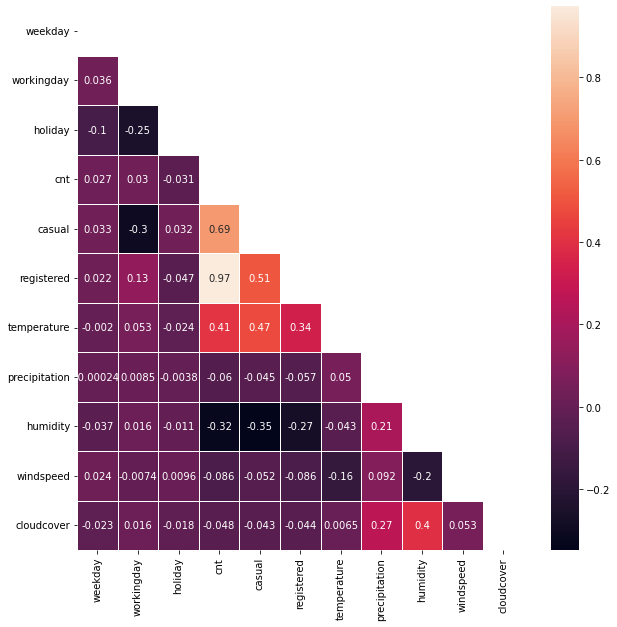

In [173]:
fig, ax = plt.subplots(figsize=(10,10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, annot=True, mask=mask, linewidths=.5, ax=ax)

In [174]:
df_complete.groupby('')['cnt'].mean()

wind_category
high      125.951220
low       191.130343
medium    153.821277
Name: cnt, dtype: float64